<a href="https://colab.research.google.com/github/shukubota/colabs/blob/main/videoconvert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os
from google.colab import drive
from google.colab.patches import cv2_imshow

def extract_frames(video_path, output_folder, max_frames=5):
    # Google Driveをマウント
    drive.mount('/content/drive')

    # ビデオファイルを開く
    video = cv2.VideoCapture(video_path)

    # 出力フォルダが存在しない場合は作成
    full_output_path = f"/content/drive/MyDrive/{output_folder}"
    if not os.path.exists(full_output_path):
        os.makedirs(full_output_path)

    # フレームカウンタ
    frame_count = 0

    frames = []

    while frame_count < max_frames:
        # フレームを読み込む
        success, frame = video.read()

        if not success:
            break

        # フレームを保存
        output_path = os.path.join(full_output_path, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(output_path, frame)

        # フレームを表示（Colab用）
        cv2_imshow(frame)

        frame_count += 1

        frames.append(frame)

    # ビデオファイルを閉じる
    video.release()

    print(f"合計 {frame_count} フレームを抽出しました。")
    print(f"フレームは {full_output_path} に保存されました。")

    return frames




In [ ]:
import cv2
import numpy as np
import base64
from PIL import Image
import io
from google.colab.patches import cv2_imshow

def detect_and_inpaint_faces(frame):
    """
    フレームから顔を検出し、inpaintingを行う関数
    Args:
        frame: cv2で読み込んだ画像（numpy.ndarray）
    Returns:
        processed_image: 処理後の画像（numpy.ndarray）
        face_mask: 顔領域のマスク（numpy.ndarray）
    """
    # 顔検出器の読み込み
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # グレースケールに変換
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 顔検出
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # マスクの作成（顔領域を白、それ以外を黒に）
    face_mask = np.zeros(frame.shape[:2], dtype=np.uint8)

    # 検出された顔領域を少し大きめに取る
    for (x, y, w, h) in faces:
        # マスクを少し大きめに
        padding = int(min(w, h) * 0.1)  # パディングを10%に設定
        x1 = max(x - padding, 0)
        y1 = max(y - padding, 0)
        x2 = min(x + w + padding, frame.shape[1])
        y2 = min(y + h + padding, frame.shape[0])

        # マスクに顔領域を追加
        cv2.rectangle(face_mask, (int(x1), int(y1)), (int(x2), int(y2)), 255, -1)

    # インペインティングの実行
    processed_image = cv2.inpaint(frame, face_mask, 3, cv2.INPAINT_TELEA)

    return processed_image, face_mask

def prepare_for_imagen(image):
    """
    画像をImagen APIで使用できる形式に変換する関数
    Args:
        image: numpy.ndarray形式の画像
    Returns:
        base64_image: Base64エンコードされた画像文字列
    """
    # OpenCV画像をPIL形式に変換
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)

    # PILイメージをバイトストリームに変換
    byte_stream = io.BytesIO()
    pil_image.save(byte_stream, format='PNG')
    byte_stream.seek(0)

    # Base64エンコード
    base64_image = base64.b64encode(byte_stream.getvalue()).decode('utf-8')

    return base64_image

def base64_to_cv2(base64_string):
    """
    Base64文字列をOpenCV画像形式に変換する関数
    """
    # Base64をデコード
    img_data = base64.b64decode(base64_string)

    # バイトデータをnumpy配列に変換
    nparr = np.frombuffer(img_data, np.uint8)

    # numpy配列をOpenCV画像に変換
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    return img

def process_frame_for_imagen(frame):
    """
    フレームを処理してImagen API用に準備する関数
    Args:
        frame: cv2で読み込んだ画像
    Returns:
        base64_processed: 処理済み画像のBase64文字列
        base64_mask: マスクのBase64文字列
    """
    # 顔検出とinpainting
    processed_image, face_mask = detect_and_inpaint_faces(frame)

    # Imagen API用にBase64エンコード
    base64_processed = prepare_for_imagen(processed_image)
    base64_mask = prepare_for_imagen(cv2.cvtColor(face_mask, cv2.COLOR_GRAY2BGR))

    return base64_processed, base64_mask

# 使用例
def main():
    # extract_framesで取得したフレームに対して処理を実行
    frame = cv2.imread("/content/drive/MyDrive/output_frames/frame_0000.jpg")

    if frame is None:
        print("画像の読み込みに失敗しました。パスを確認してください。")
        return

    # 処理の実行
    base64_processed, base64_mask = process_frame_for_imagen(frame)

    # 処理結果の確認
    processed_img = base64_to_cv2(base64_processed)
    mask_img = base64_to_cv2(base64_mask)

    # 結果の表示
    print("処理済み画像:")
    cv2_imshow(processed_img)
    print("\nマスク画像:")
    cv2_imshow(mask_img)

    return base64_processed, base64_mask

# extract_frames関数で使用する場合の例
def process_video_frame(frame):
    """
    ビデオフレームを処理する関数
    """
    base64_processed, base64_mask = process_frame_for_imagen(frame)

    # 結果の表示（必要に応じて）
    processed_img = base64_to_cv2(base64_processed)
    mask_img = base64_to_cv2(base64_mask)

    print("処理済み画像:")
    cv2_imshow(processed_img)
    print("\nマスク画像:")
    cv2_imshow(mask_img)

    return base64_processed, base64_mask

In [3]:
!pip install insightface==0.7.3
!pip install onnxruntime-gpu
!pip install mediapipe opencv-python-headless pillow numpy insightface

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
スワップ画像サイズ: (1536, 1214, 3)


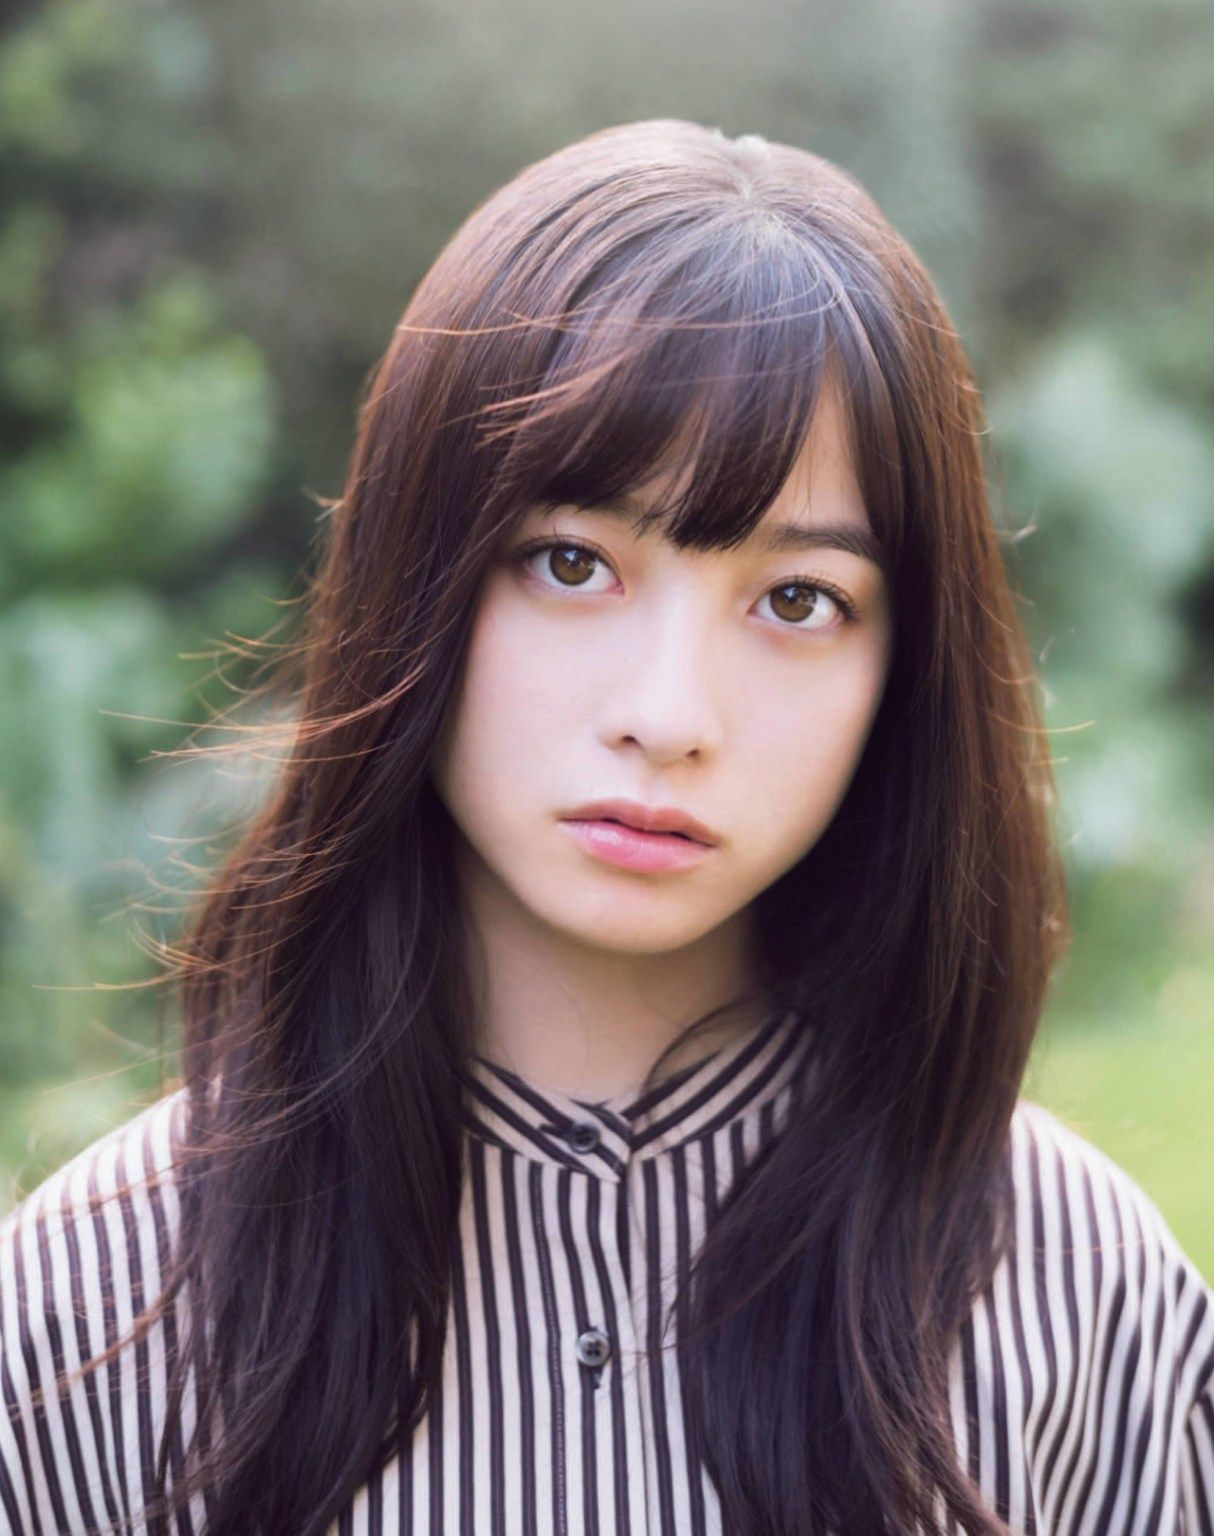

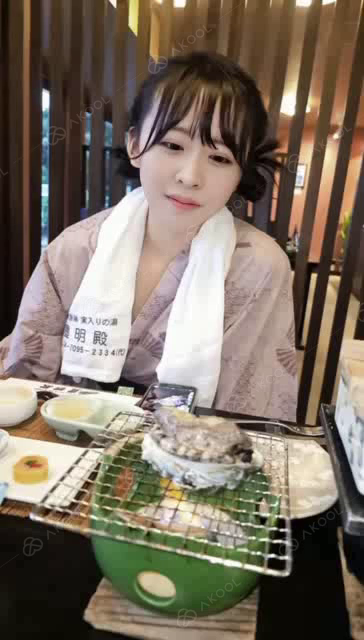

合計 1 フレームを抽出しました。
フレームは /content/drive/MyDrive/output_frames に保存されました。
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition 

/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


スワップ後の画像:


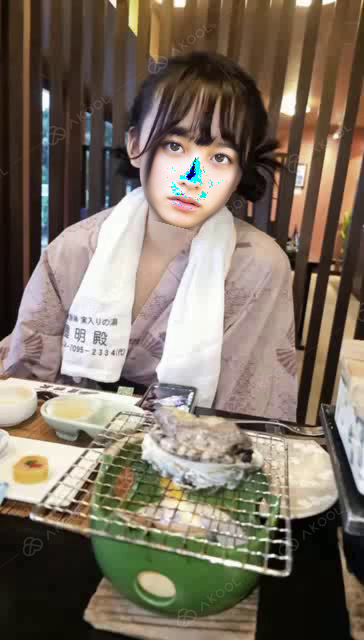

マスク:


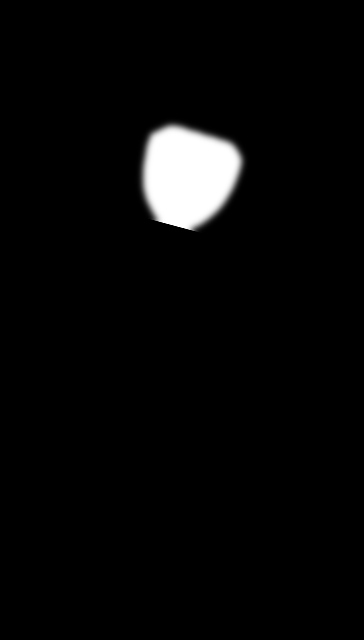

In [7]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow
from google.colab import drive
import base64
from PIL import Image
import io
import insightface
from insightface.app import FaceAnalysis
from insightface.utils import face_align
import urllib.request

def download_model():
    """InsightFaceのモデルをダウンロード"""
    model_url = "https://github.com/deepinsight/insightface/releases/download/v0.7/buffalo_l.zip"
    model_path = "buffalo_l"
    if not os.path.exists(model_path):
        os.makedirs(model_path)
        urllib.request.urlretrieve(model_url, "buffalo_l.zip")
        !unzip buffalo_l.zip -d buffalo_l/

def prepare_for_imagen(image):
    """画像をBase64エンコード"""
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    buffer = io.BytesIO()
    image_pil.save(buffer, format='PNG')
    return base64.b64encode(buffer.getvalue()).decode('utf-8')


def face_swap(source_img, target_img, app):
    """InsightFaceを使用した顔のスワップ"""
    try:
        # 固定サイズを設定（112の倍数）
        ALIGN_SIZE = 224  # 112 * 2

        # 顔の検出
        source_faces = app.get(source_img)
        target_faces = app.get(target_img)

        if len(source_faces) == 0 or len(target_faces) == 0:
            print("顔の検出に失敗しました")
            return target_img, np.zeros_like(target_img)

        source_face = source_faces[0]
        target_face = target_faces[0]

        # キーポイントの取得
        src_kps = source_face.kps
        dst_kps = target_face.kps

        # 変換行列の計算
        tform = face_align.estimate_norm(src_kps, ALIGN_SIZE)
        source_aligned = cv2.warpAffine(source_img, tform, (ALIGN_SIZE, ALIGN_SIZE), borderValue=0.0)

        tform_target = face_align.estimate_norm(dst_kps, ALIGN_SIZE)
        target_aligned = cv2.warpAffine(target_img, tform_target, (ALIGN_SIZE, ALIGN_SIZE), borderValue=0.0)

        # ランドマークポイントの変換
        if hasattr(target_face, 'landmark_2d_106'):
            landmarks = target_face.landmark_2d_106
        else:
            landmarks = target_face.landmark_2d

        # ランドマークを変換後の座標系に変換
        landmarks_transformed = []
        for point in landmarks:
            x, y = point
            point_array = np.array([x, y, 1])
            transformed_point = np.dot(tform_target, point_array)
            landmarks_transformed.append(transformed_point[:2])
        landmarks_transformed = np.array(landmarks_transformed, dtype=np.int32)

        # マスクの生成（アライメントされたサイズで）
        mask = np.zeros((ALIGN_SIZE, ALIGN_SIZE, 3), dtype=np.uint8)
        hull = cv2.convexHull(landmarks_transformed)
        cv2.fillConvexPoly(mask, hull, (255, 255, 255))

        # マスクのブラー処理
        mask = cv2.GaussianBlur(mask, (31, 31), 0)

        # 顔領域の抽出
        face_region = cv2.bitwise_and(source_aligned, source_aligned, mask=mask[:,:,0])

        # 色調補正
        source_mean = cv2.mean(source_aligned, mask=mask[:,:,0])
        target_mean = cv2.mean(target_aligned, mask=mask[:,:,0])
        correction = np.array([t/s if s != 0 and s > 1 else 1 for s, t in zip(source_mean, target_mean)])
        face_region = cv2.multiply(face_region.astype(float), correction).astype(np.uint8)

        # マスクの正規化
        mask_normalized = mask.astype(float) / 255.0

        # アライメントされた空間での合成
        result = target_aligned.copy()
        for c in range(3):
            result[:, :, c] = (face_region[:, :, c] * mask_normalized[:, :, c] +
                              target_aligned[:, :, c] * (1 - mask_normalized[:, :, c]))

        # 元の画像サイズに戻す
        inverse_tform = cv2.invertAffineTransform(tform_target)
        result = cv2.warpAffine(result, inverse_tform, (target_img.shape[1], target_img.shape[0]))
        final_mask = cv2.warpAffine(mask, inverse_tform, (target_img.shape[1], target_img.shape[0]))

        # 最終的なブレンド
        final_mask_normalized = final_mask.astype(float) / 255.0
        final_result = target_img.copy()
        for c in range(3):
            final_result[:, :, c] = (result[:, :, c] * final_mask_normalized[:, :, c] +
                                    target_img[:, :, c] * (1 - final_mask_normalized[:, :, c]))

        return final_result, final_mask

    except Exception as e:
        print(f"エラーが発生しました: {str(e)}")
        import traceback
        traceback.print_exc()
        return target_img, np.zeros_like(target_img)
def process_frame_for_imagen(frame, swap_image):
    """フレーム処理とスワップ"""
    # Face Analyserの初期化
    app = FaceAnalysis(name='buffalo_l')
    app.prepare(ctx_id=0, det_size=(640, 640))

    # 顔のスワップを実行
    result, mask = face_swap(swap_image, frame, app)

    # Base64エンコード
    base64_processed = prepare_for_imagen(result)
    base64_mask = prepare_for_imagen(mask)

    return base64_processed, base64_mask

def extract_frames(video_path, output_folder, max_frames=5):
    """ビデオからフレームを抽出"""
    video = cv2.VideoCapture(video_path)
    full_output_path = f"/content/drive/MyDrive/{output_folder}"
    if not os.path.exists(full_output_path):
        os.makedirs(full_output_path)

    frame_count = 0
    frames = []

    while frame_count < max_frames:
        success, frame = video.read()
        if not success:
            break

        output_path = os.path.join(full_output_path, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(output_path, frame)
        cv2_imshow(frame)

        frame_count += 1
        frames.append(frame)

    video.release()
    print(f"合計 {frame_count} フレームを抽出しました。")
    print(f"フレームは {full_output_path} に保存されました。")

    return frames

def main():
    try:
        # パスの設定
        video_path = "/content/drive/MyDrive/videoconvert/raw.mov"
        output_folder = "output_frames"
        swap_image_path = "/content/drive/MyDrive/videoconvert/hashikan2.jpeg"

        # Google Driveのマウント
        drive.mount('/content/drive')

        # InsightFaceのモデルをダウンロード
        download_model()

        # スワップ用の画像を読み込み
        swap_image = cv2.imread(swap_image_path)
        if swap_image is None:
            print("スワップ画像の読み込みに失敗しました。")
            return

        print(f"スワップ画像サイズ: {swap_image.shape}")
        cv2_imshow(swap_image)

        # ビデオからフレームを抽出
        max_frames = 1
        frames = extract_frames(video_path, output_folder, max_frames)

        if not frames:
            print("フレームの抽出に失敗しました。")
            return

        frame = frames[0]

        # 顔のスワップ処理を実行
        base64_processed, base64_mask = process_frame_for_imagen(frame, swap_image)

        # 結果の表示
        processed_img_np = np.frombuffer(base64.b64decode(base64_processed), np.uint8)
        mask_img_np = np.frombuffer(base64.b64decode(base64_mask), np.uint8)

        processed_img = cv2.imdecode(processed_img_np, cv2.IMREAD_COLOR)
        mask_img = cv2.imdecode(mask_img_np, cv2.IMREAD_COLOR)

        print("スワップ後の画像:")
        cv2_imshow(processed_img)
        print("マスク:")
        cv2_imshow(mask_img)

        return base64_processed, base64_mask

    except Exception as e:
        print(f"エラーが発生しました: {str(e)}")
        return None, None

if __name__ == "__main__":
    # 必要なライブラリのインストール
    !pip install insightface==0.7.3
    !pip install onnxruntime-gpu

    main()

In [ ]:
import insightface
print(insightface.__version__)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


0.7.3
